In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
# Spotify API creditionals
client_id = "Your Client ID"
client_secret = "Your Client Password"
# API authentication
cred_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=cred_manager)

In [3]:
# function to get the artsists' IDs
def get_artist_id(artist_name):
    result = sp.search(q=artist_name, type="artist", limit=1) # search for artist name
    if result['artists']['items']:
        artist_id = result['artists']['items'][0]['id'] # get id from spotify
        return artist_id
    else: 
        print(f" The artist {artist_name} was not found")
        return None

In [4]:
# function to find artists who worked w/ given artist by checking featured tracks
def get_collaborating_artists(artist_id):
    collaborations = set()
    
    # get top tracks of the artist
    top_tracks = sp.artist_top_tracks(artist_id)['tracks']
    
    for track in top_tracks:
        for artist in track['artists']:
            if artist['id'] != artist_id:  # to avoid self-links
                collaborations.add(artist['id'])
    
    return collaborations

In [5]:
# function to beuild artist collaboration network 
# starts from a given artist
def build_collaboration_graph(given_artist):
    G = nx.Graph()
    
    given_artist_id = get_artist_id(given_artist)
    if not given_artist_id:
        print("Artist not found.")
        return None
    
    # add the given artist as a starting node
    G.add_node(given_artist)
    
    # get direct collaborators
    collaborators = get_collaborating_artists(given_artist_id)
    
    for collab_id in collaborators:
        collab_name = sp.artist(collab_id)['name']
        G.add_node(collab_name)
        G.add_edge(given_artist, collab_name)
    
        # expand the network from there with collaborators of the collaborators
        second_degree_collabs = get_collaborating_artists(collab_id)
        for second_collab_id in second_degree_collabs:
            second_collab_name = sp.artist(second_collab_id)['name']
            G.add_node(second_collab_name)
            G.add_edge(collab_name, second_collab_name)
            
    print(f"Network built - total artists: {len(G.nodes)} and total connections: {len(G.edges)}")
    return G

In [22]:
# function to find artist with highest degree centrality
def most_connected_artist(G, n=3):
    if G is None:
        return None

    degree_counts = dict(G.degree())
    most_connected = sorted(degree_counts.items(), key=lambda x: x[1], reverse=True)[:n]
    # most_connected = max(degree_counts, key=degree_counts.get)
    
    print(f"The top {n} most collaberative artists in this network are:")
    for artist, degree in most_connected:
        print(f"{artist} with {degree} collaberations")
    return most_connected

In [7]:
# function to visualize the artist collaborations on spotify 
def visualize_network(G):
    if G is None:
        return
    
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", font_size=8, node_size=500)
    plt.title("Spotify Artist Collaboration Network")
    plt.show()

Network built - total artists: 25 and total connections: 28
The top 3 most collaberative artists in this network are:
MC Abdul with 8 collaberations
Saint Levant with 7 collaberations
TIF with 5 collaberations


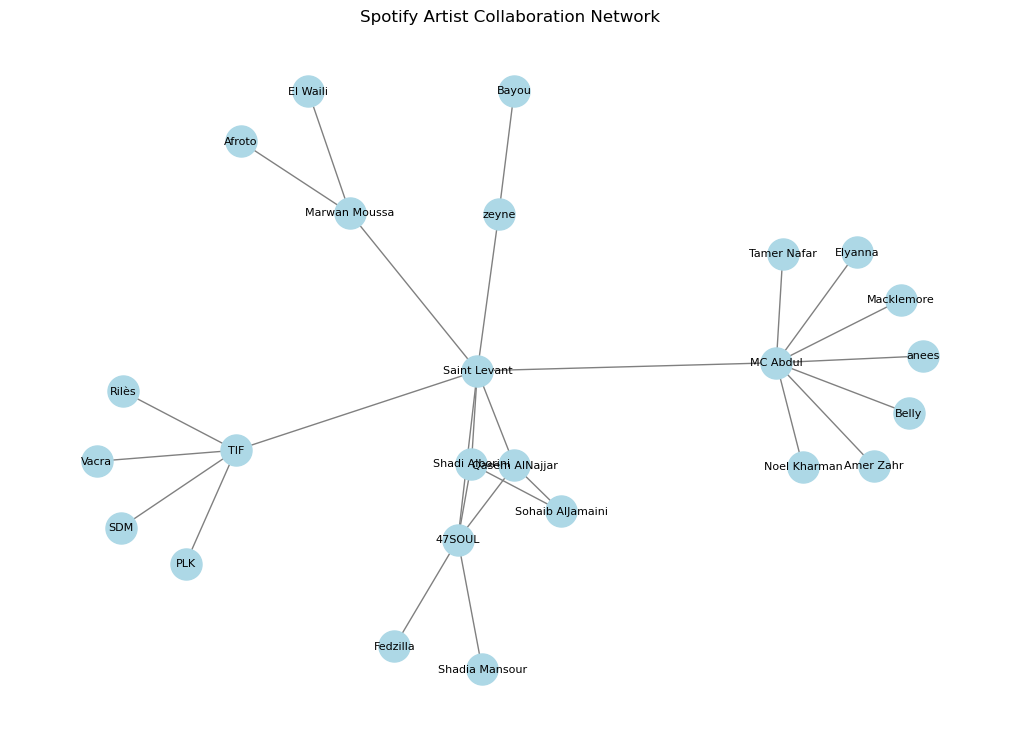

In [24]:
# choose a starting artist 
given_artist = "Saint Levant"

# build the network
G = build_collaboration_graph(given_artist)

# find the most collaborative artist
most_connected_artist(G)

# visualize the network
visualize_network(G)